In [17]:
import pandas as pd
import seaborn as sns
import textacy
import textacy.preprocessing as tprep

import numpy as np
import math
import re 
import nltk
import os
import time

In [18]:
df = pd.read_csv("products.csv")
brands = list(set(list(df["brand"])))

In [43]:
display(df)

,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,store,url,category,subcategory,fullname
0,21616sh 006,880016036,nan,"[""https://media.hartlauer.at/m/33143559c767b7f...",calvin klein jeans,NaN,NaN,InStock,EUR,129.0,hartlauer.at,https://www.hartlauer.at/produkt/calvin-klein-...,eyewear,sunglasses,21616sh 006 calvin klein jeans
1,05h ry214s,880014894,nan,"[""https://media.hartlauer.at/m/4a53848459c65d6...",replay,NaN,NaN,InStock,EUR,129.0,hartlauer.at,https://www.hartlauer.at/produkt/replay-ry214s...,eyewear,sunglasses,05h ry214s replay
2,daps103-04h,880014816,nan,"[""https://media.hartlauer.at/m/3782093410ed8c5...",davidoff,NaN,NaN,InStock,EUR,129.0,hartlauer.at,https://www.hartlauer.at/produkt/davidoff-daps...,eyewear,sunglasses,daps103-04h davidoff
3,daps109-05h,880014780,nan,"[""https://media.hartlauer.at/m/fa0ab552476cd6c...",davidoff,NaN,NaN,InStock,EUR,129.0,hartlauer.at,https://www.hartlauer.at/produkt/davidoff-daps...,eyewear,sunglasses,daps109-05h davidoff
4,osm ry521s04h,880018055,nan,"[""https://media.hartlauer.at/m/388aed8f1c5f112...",replay,NaN,NaN,InStock,EUR,99.0,hartlauer.at,https://www.hartlauer.at/produkt/replay-osm-ry...,eyewear,sunglasses,osm ry521s04h replay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34877,002 pu0421o,puma-pu0421o-002-gun_blau-23987,blue gun,"[""images/d04ac2a17227f6bb95d913209a526628.png""...",puma,NaN,Metall,InStock,EUR,168.9,fielmann,https://www.fielmann.at/p/puma-pu0421o-002-gun...,eyewear,glasses,002 pu0421o puma
34878,091 sp5026,adidas-sp5026-091-blau_silber-21577,blue silber,"[""images/f181dcb2f3091b777502e5b3bc1cf75b.png""...",adidas,NaN,Metall,InStock,EUR,159.9,fielmann,https://www.fielmann.at/p/adidas-sp5026-091-bl...,eyewear,glasses,091 sp5026 adidas
34879,001 pu0431o,puma-pu0431o-001-schwarz-23986,black,"[""images/e8486482f39728314224247d0ab0ba33.png""...",puma,NaN,Kunststoff,InStock,EUR,104.9,fielmann,https://www.fielmann.at/p/puma-pu0431o-001-sch...,eyewear,glasses,001 pu0431o puma
34880,046 cv3015,converse-cv3015-046-silber_rose-21574,silber rose,"[""images/0c2897da338c1e422ead4c1e2814cf10.png""...",converse,NaN,Metall,InStock,EUR,151.9,fielmann,https://www.fielmann.at/p/converse-cv3015-046-...,eyewear,glasses,046 cv3015 converse


In [19]:
def map_color(color):
    color = str(color)
    color = color.lower()
    mappings1 = [
        ("-", " "), ("/", " "), (",", " "), ("\t", " "), ("farben", ""), ("_", " "),
        ("é", "e")
    ]
    mappings2 = [
        ("schwarz", "black"), ("blck", "black"), ("weiß", "white"), ("weiss", "white"),
        ("blau", "blue"), ("gelb", "yellow"), ("rot", "red"), 
        ("violett", "purple"), ("grün", "green"), ("gruen", "green"), ("grau", "grey"), 
        ("havana", "havanna"), ("kupfer", "copper"),
        ("braun", "brown"), ("hell", "bright"), ("glanz", "shiny"), 
        ("dunkel", "dark"), ("glänzend", "shiny"), ("verlauf", " gradient"), ("matt", "matte"), ("transp ", "transparent "),
    ]
    for mapping in mappings1:
        color = color.replace(mapping[0], mapping[1])
        
    # collapse whitespace
    rex = re.compile(r'\W+')
    color = rex.sub(' ', color)
    
    # deduplicate colors
    colors_arr = color.split(" ")
    colors_arr = list(set(colors_arr))
    colors_arr
    
    for mapping in mappings2:
        for i in range(len(colors_arr)):
            colors_arr[i] = colors_arr[i].replace(mapping[0], mapping[1])
            colors_arr[i] = colors_arr[i].strip()
    color = " ".join(colors_arr)
    
    return color
        
df["color"] = df["color"].apply(map_color)

In [20]:
def map_brand(brand):
    brand = brand.lower()
    mappings = [("®", "")]
    for mapping in mappings:
        brand = brand.replace(mapping[0], mapping[1])
        
    brand = textacy.preprocessing.normalize.hyphenated_words(brand)
    brand = textacy.preprocessing.normalize.quotation_marks(brand)
    brand = textacy.preprocessing.normalize.unicode(brand)
    brand = textacy.preprocessing.remove.accents(brand)
    return brand

df["brand"] = df["brand"].apply(map_brand)

In [21]:
allwords = set()
def map_name(name):
    name = name.lower()
    for brand in brands:
        name = name.replace(brand, "")
    mappings = [
        ("sonnenbrille", ""), ("brille", ""),
    ]
    for mapping in mappings:
        name = name.replace(mapping[0], mapping[1])
        
    for w in name.split(" "):
            allwords.add(w)
    
    return name

df["name"] = df["name"].apply(map_name)

In [22]:
tagged_words_all = nltk.pos_tag(allwords, tagset='universal')
tagged_words_dict = {}
for w in tagged_words_all:
    tagged_words_dict[w[0]] = w[1]

In [23]:
def map_name2(name):
    tmp_words = name.split(" ")
    tagged_words = []
    for w in tmp_words:
        tagged_words.append((w, tagged_words_dict[w]))
    for i, word in enumerate(tagged_words):
        if word[1] == "NUM":
            tagged_words[i] = (tagged_words[i][0], 0)
        elif len(word[0]) <= 2:
            tagged_words[i] = (tagged_words[i][0], 0)
        else:
            tagged_words[i] = (tagged_words[i][0], 2)
        
    new_words = []
    for i, word in enumerate(tagged_words):
        j = 0
        while True:
            if j == len(new_words):
                new_words.append(word)
                break
            if word[1] < new_words[j][1]:
                new_words.insert(j, word)
                break
            j+=1
        
    new_words = [v[0] for v in new_words]
    name = " ".join(new_words)
    return name
df["name"] = df["name"].apply(map_name2)

In [24]:
df["fullname"] =df["name"] + " " + df["brand"]
len(df)
len(df["brand"].value_counts())

259

In [9]:
df[(df["brand"] == "ray-ban") & (df["name"].str.contains("3025"))].groupby("store").head(1)

,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,store,url,category,subcategory,fullname
11131,rb 3025 aviator large l2823,4730,black,[],ray-ban,NaN,NaN,InStock,EUR,164.95,misterspex.at,https://www.misterspex.at/p/sg/4730,eyewear,sunglasses,rb 3025 aviator large l2823 ray-ban
22086,0rb3025 019/z2 aviator large metal,8053672158656,silber,"[""https://gv-flexvault.imgix.net/8053672158656...",ray-ban,NaN,Metall,InStock,EUR,175.00,pearle.at,https://www.pearle.at/sonnenbrillen/p-ray-ban-...,eyewear,sunglasses,0rb3025 019/z2 aviator large metal ray-ban


In [10]:
df[(df["name"].str.contains("3025")) & (df["name"].str.contains("019/z2"))]

,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,store,url,category,subcategory,fullname
11631,rb 3025 019/z2 aviator small,6662820,silver matte,[],ray-ban,NaN,NaN,InStock,EUR,144.95,misterspex.at,https://www.misterspex.at/p/sg/6662820,eyewear,sunglasses,rb 3025 019/z2 aviator small ray-ban
22086,0rb3025 019/z2 aviator large metal,8053672158656,silber,"[""https://gv-flexvault.imgix.net/8053672158656...",ray-ban,NaN,Metall,InStock,EUR,175.00,pearle.at,https://www.pearle.at/sonnenbrillen/p-ray-ban-...,eyewear,sunglasses,0rb3025 019/z2 aviator large metal ray-ban


store,fielmann,hartlauer.at,misterspex.at,pearle.at
0,NaN,129.0,NaN,NaN
1,NaN,129.0,NaN,NaN
2,NaN,129.0,NaN,NaN
3,NaN,129.0,NaN,NaN
4,NaN,99.0,NaN,NaN
...,...,...,...,...
34877,168.9,NaN,NaN,NaN
34878,159.9,NaN,NaN,NaN
34879,104.9,NaN,NaN,NaN
34880,151.9,NaN,NaN,NaN


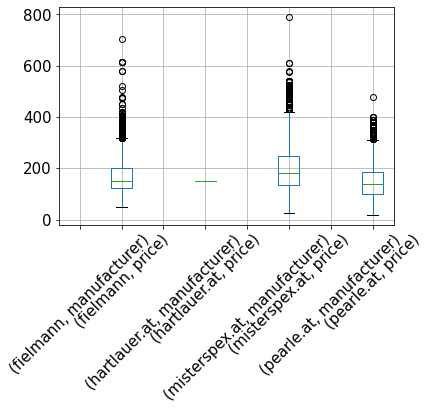

In [33]:
df2 = df[(df["subcategory"] == "glasses")]
p = df2.groupby("store")
p.boxplot("price", rot=45, fontsize=15)
df.pivot_table(values='price', index=df.index, columns='store', aggfunc='first')

In [80]:
len(df)

34882

<Axes: xlabel='store'>

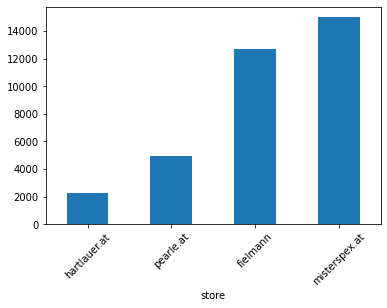

In [84]:
df.groupby("store").size().sort_values().plot(kind="bar", rot=45)

In [168]:
df.groupby("store").size().sort_values().to_frame().to_csv("tableau/retailer_product_count.csv")

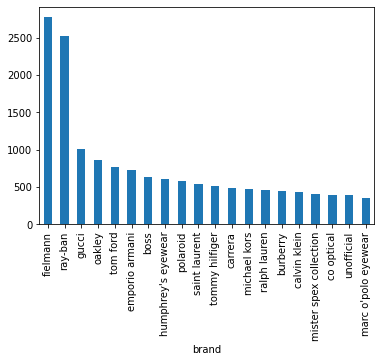

In [174]:
p = df.groupby("brand").size().sort_values(ascending=False).head(20)
p.plot(kind="bar")
p.to_frame().to_csv("tableau/brand_product_count.csv")

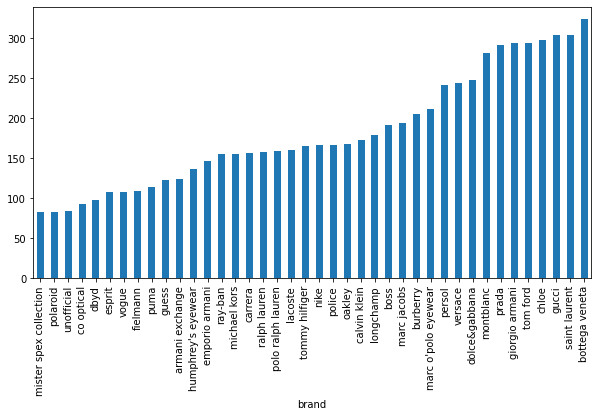

In [13]:
# brand price correlation
bp = df.groupby(["brand"])["price"].describe()
bp = bp[bp["count"] > 250]
p = bp["mean"].sort_values()
p.plot(kind="bar", figsize=(10, 5))
p.to_frame().to_csv("tableau/brand_price_corr.csv")

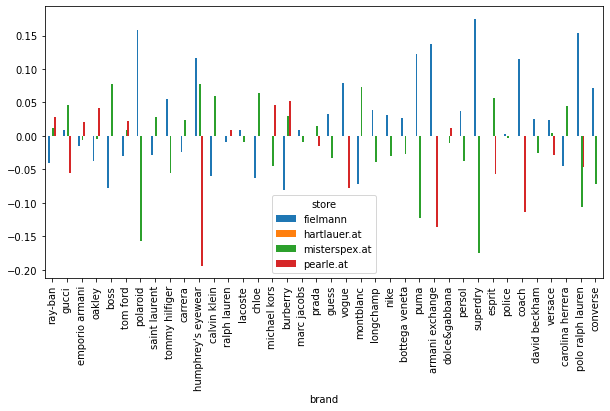

In [14]:
# brand price correlation
bp = df.groupby(["store", "brand"])["price"].describe()
bp = bp[bp["count"] > 20]
bp = bp.sort_values(by="count", ascending=False).head(150)
b = bp["mean"].unstack("store")


b["mean"] = b.mean(axis=1)
# b = b.reset_index()



b["fielmann"] = (b["fielmann"] - b["mean"]) / b["mean"]
b["hartlauer.at"] = (b["hartlauer.at"] - b["mean"]) / b["mean"]
b["misterspex.at"] = (b["misterspex.at"] - b["mean"]) / b["mean"]
b["pearle.at"] = (b["pearle.at"] - b["mean"]) / b["mean"]
# b["hartlauer.at"] -= b["mean"]
# b["misterspex.at"] -= b["mean"]
# b["pearle.at"] -= b["mean"]
del b['mean']

b = b.fillna(0)
b = b[b.any(axis=1)]
# b.set_index("brand", inplace=True)
b.plot(kind="bar", figsize=(10, 5))
b.to_csv("tableau/brand_price_mean_deviation_by_retailer.csv")



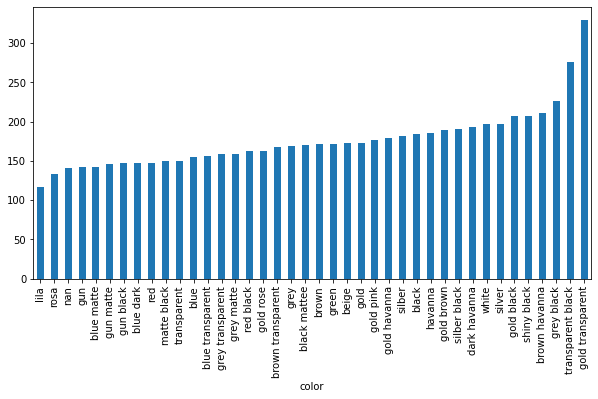

In [15]:
# color price correlation
bp = df.groupby(["color"])["price"].describe()
bp = bp[bp["count"] > 100]
p = bp["mean"].sort_values().head(50)
p.plot(kind="bar", figsize=(10, 5))
p.to_csv("tableau/color_price_corr.csv")

<Axes: xlabel='color', ylabel='count'>

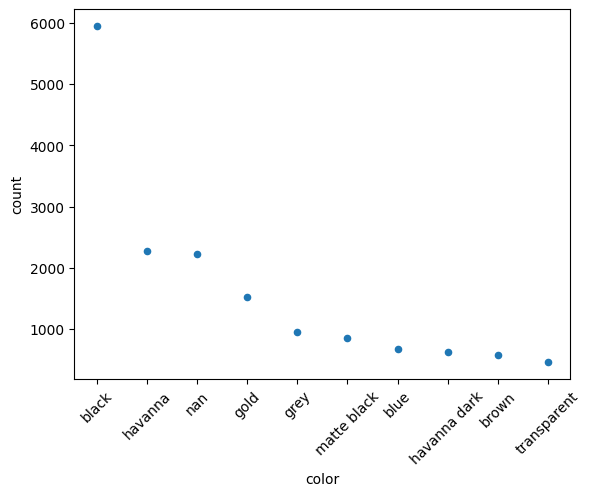

In [217]:
df["color"].value_counts().head(10).to_frame().reset_index("color").plot(kind="scatter", x="color", y="count", rot=45)

In [218]:
mrspex = df[df["store"] == "misterspex.at"]["fullname"]
fielmann = df[df["store"] == "fielmann"]["fullname"]

In [17]:
def ngrams(string, n=3):
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]
def gen_tokens(text):
    return ngrams(text)

def gen_alltokens(series):
    alltokens = set()
    for v in series:
        tokens = gen_tokens(v)
        for token in tokens:
            alltokens.add(token)
    alltokens = sorted(list(alltokens))
    return alltokens

def gen_tf_matrix(series):
    tf_matrix = []
    for quote in series:
        words = gen_tokens(quote)
        
        # initialization
        tf = {}
        for word in alltokens: tf[word] = 0
        
        # counting
        for word in words: tf[word] += 1
    
        # Normalizing
        for k in tf: tf[k] = (tf[k])/len(words)
            
        # prioritizing front
#         for i, word in enumerate(words): 
#             # percentage till end
#             priority = 1-(i/len(words))
#             # sigmoid
#             priority = 1/(1+math.e**(-3*priority))
            
#             tf[word] *= priority
        
        tf = sorted(tf.items())
        tf = [v[1] for v in tf]
    
        tf_matrix.append(tf)
        
    return np.matrix(tf_matrix)

def gen_idf_vector(series):
    idf = {}

    #init
    for word in alltokens: idf[word] = 0
        
    for quote in series:
        words = gen_tokens(quote)
        words = list(set(words))
    
        for word in words:
            idf[word] += 1

    for k in idf:
        idf[k] = math.log(len(series)/idf[k])
           
    idf = sorted(idf.items())
    idf = [v[1] for v in idf]
    idf = np.array(idf)
    return idf

def cosine_similarity2(i, df, recursion=0): 
    matches = []
    v_query = tf_idf_df.iloc[i].to_numpy()

    for index, row in tf_idf_df.iterrows():
        b = row.to_numpy()
#         b = tf_idf_df.iloc[index].to_numpy()
        sim = np.dot(v_query, b)/(np.linalg.norm(v_query)*np.linalg.norm(b))

        if sim > 0.5:
#             if sim > 0.6 and recursion < 1:
#                 recursion += 1
#                 matches += cosine_similarity2(index, df, recursion)
            matches.append((index, sim))
     
    matches = list(set(matches))
    return matches

In [18]:
search_df = df[df["brand"] == "adidas"]

alltokens = gen_alltokens(search_df["fullname"])
tf_matrix = gen_tf_matrix(search_df["fullname"])
v_idf = gen_idf_vector(search_df["fullname"])
tf_idf_matrix = np.multiply(tf_matrix, v_idf)
tf_idf_df = pd.DataFrame(tf_idf_matrix, columns=alltokens)

In [63]:
c = 0


for name, search_df in df.groupby("brand"):
    c+=1

    alltokens = gen_alltokens(search_df["fullname"])
    tf_matrix = gen_tf_matrix(search_df["fullname"])
    v_idf = gen_idf_vector(search_df["fullname"])
    tf_idf_matrix = np.multiply(tf_matrix, v_idf)
    tf_idf_df = pd.DataFrame(tf_idf_matrix, columns=alltokens)
    
    product_names = []
    product_brands = []
    price_diff_data = []

    for i in range(len(search_df)):
        matches1 = cosine_similarity2(i, search_df)
        display_df = search_df.take([v[0] for v in matches1])
        display_df["similarity"] = [v[1] for v in matches1]

        df_tmp = display_df.sort_values(by="similarity", ascending=False).drop_duplicates("product_id").groupby("store").first()
    
        if len(df_tmp) == 0: 
            continue
        
        display(df_tmp)
            
        product_names.append(df_tmp.iloc[0]["fullname"])
        product_brands.append(df_tmp.iloc[0]["brand"])
        price_diff_data.append(df_tmp.price)
    
    if c >= 1: break

    price_diff_df = pd.DataFrame(price_diff_data)
    price_diff_df["mean"] = price_diff_df.mean(axis=1)
    price_diff_df["name"] = product_names
    price_diff_df["brand"] = product_brands

#     price_diff_df["fielmann"] = (price_diff_df["fielmann"] - price_diff_df["mean"]) / price_diff_df["mean"]
#     price_diff_df["misterspex.at"] = (price_diff_df["misterspex.at"] - price_diff_df["mean"]) / price_diff_df["mean"]
#     price_diff_df["pearle.at"] = (price_diff_df["pearle.at"] - price_diff_df["mean"]) / price_diff_df["mean"]
#     price_diff_df["mean"] -= price_diff_df["mean"]
      

,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,url,category,subcategory,fullname,similarity
store,,,,,,,,,,,,,,,
misterspex.at,cherry blossom,6832100,light tortoise gold,[],aboxofsweets x mister spex,NaN,None,InStock,EUR,99.95,https://www.misterspex.at/p/pg/6832100,eyewear,glasses,cherry blossom aboxofsweets x mister spex,1.0


,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,url,category,subcategory,fullname,similarity
store,,,,,,,,,,,,,,,
misterspex.at,earth,6793699,havanna,[],aboxofsweets x mister spex,NaN,None,InStock,EUR,99.95,https://www.misterspex.at/p/pg/6793699,eyewear,glasses,earth aboxofsweets x mister spex,1.0


,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,url,category,subcategory,fullname,similarity
store,,,,,,,,,,,,,,,
misterspex.at,rose,6832101,gold transp rose,[],aboxofsweets x mister spex,NaN,None,InStock,EUR,99.95,https://www.misterspex.at/p/pg/6832101,eyewear,glasses,rose aboxofsweets x mister spex,1.0


,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,url,category,subcategory,fullname,similarity
store,,,,,,,,,,,,,,,
misterspex.at,1002 fly away p23,6859531,green,[],aboxofsweets x mister spex,NaN,None,InStock,EUR,99.95,https://www.misterspex.at/p/pg/6859531,eyewear,glasses,1002 fly away p23 aboxofsweets x mister spex,1.0


,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,url,category,subcategory,fullname,similarity
store,,,,,,,,,,,,,,,
misterspex.at,sandstone,6857268,grey transp,[],aboxofsweets x mister spex,NaN,None,InStock,EUR,99.95,https://www.misterspex.at/p/pg/6857268,eyewear,glasses,sandstone aboxofsweets x mister spex,1.0


,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,url,category,subcategory,fullname,similarity
store,,,,,,,,,,,,,,,
misterspex.at,1002 fly away d22,6857267,grey transp,[],aboxofsweets x mister spex,NaN,None,InStock,EUR,99.95,https://www.misterspex.at/p/pg/6857267,eyewear,glasses,1002 fly away d22 aboxofsweets x mister spex,1.0


,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,url,category,subcategory,fullname,similarity
store,,,,,,,,,,,,,,,
misterspex.at,ice,6793700,transparent,[],aboxofsweets x mister spex,NaN,None,InStock,EUR,99.95,https://www.misterspex.at/p/pg/6793700,eyewear,glasses,ice aboxofsweets x mister spex,1.0


,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,url,category,subcategory,fullname,similarity
store,,,,,,,,,,,,,,,
misterspex.at,1002 fly away r31,6857266,brown,[],aboxofsweets x mister spex,NaN,None,InStock,EUR,99.95,https://www.misterspex.at/p/pg/6857266,eyewear,glasses,1002 fly away r31 aboxofsweets x mister spex,1.0


,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,url,category,subcategory,fullname,similarity
store,,,,,,,,,,,,,,,
misterspex.at,sunbird,6832104,silver,[],aboxofsweets x mister spex,NaN,None,InStock,EUR,79.95,https://www.misterspex.at/p/sg/6832104,eyewear,sunglasses,sunbird aboxofsweets x mister spex,1.0


In [34]:
pdiff = pd.read_csv("data/pricematch.csv")
del pdiff["mean"]
del pdiff["Unnamed: 0"]
del pdiff["hartlauer.at"]
pdiff.groupby("brand").mean(numeric_only=True).sort_values(by="fielmann", ascending=False)
f = pdiff[pdiff["brand"] == "ray-ban"].sort_values(by="fielmann", ascending=False)["fielmann"].dropna()
f[f!=0].mean()

-0.035459670549820105

<Axes: xlabel='brand'>

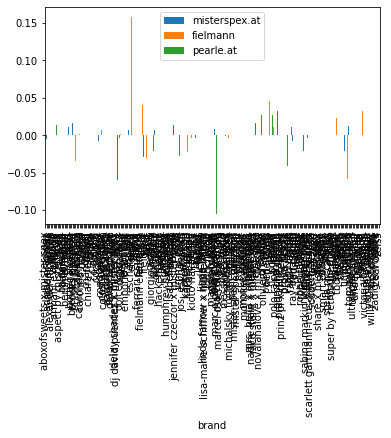

In [35]:
pdiff.groupby("brand").mean(numeric_only=True).plot(kind="bar")

,misterspex.at,fielmann,pearle.at,sum
brand,,,,
adidas,-0.120224,NaN,0.120224,3.885781e-16
boss,-0.058961,0.058961,NaN,9.011888e-16
botaniq,-0.275911,0.275911,NaN,4.440892e-16
bottega veneta,-0.031055,0.031055,NaN,7.010734e-16
brendel eyewear,-0.307944,NaN,0.307944,4.440892e-16
burberry,0.056900,-0.071584,0.062694,4.758563e-16
calvin klein,-0.232794,0.232794,NaN,7.771561e-16
calvin klein jeans,NaN,0.019414,NaN,7.765712e-02
carrera,-0.050740,0.050740,NaN,8.049117e-16


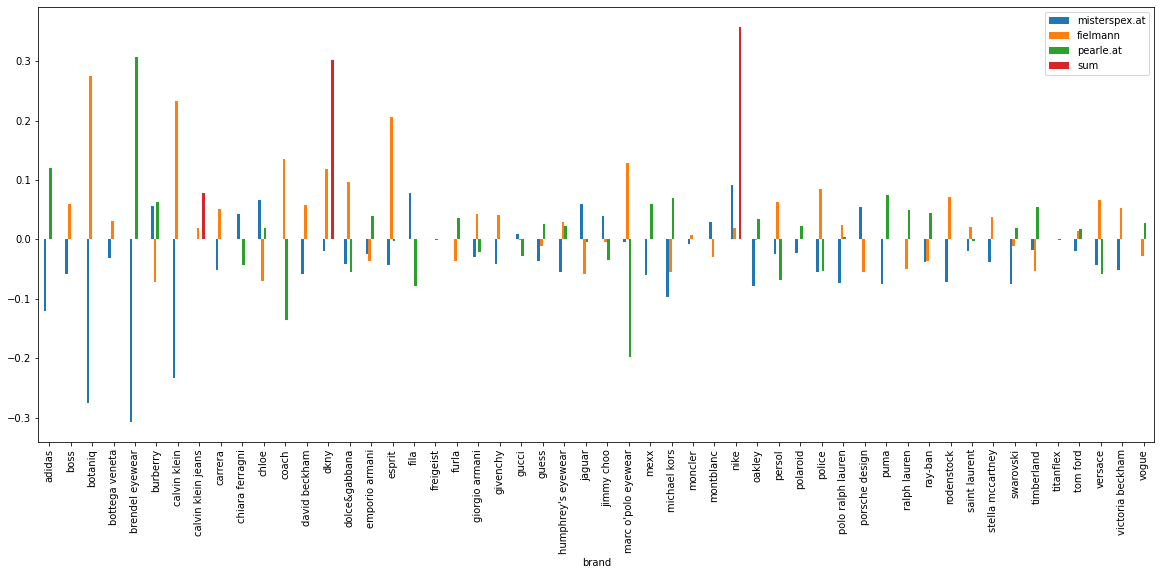

In [39]:
pdiff["sum"] = pdiff.sum(axis=1, numeric_only=True)
p = pdiff[pdiff["sum"] > 0].sort_values(by="sum").groupby("brand").mean(numeric_only=True)
p.plot(kind="bar", figsize=(20, 8))
p.to_csv("tableau/brand_price_real_mean_deviation_by_retailer.csv")
p

In [163]:
pdiff[pdiff["sum"] > 0]["misterspex"].mean()

KeyError: 'misterspex'

In [59]:
%%time

product_names = []
product_brands = []
price_diff_data = []

for i in range(len(search_df)):
    matches1 = cosine_similarity2(i, search_df)
    display_df = search_df.take([v[0] for v in matches1])
    display_df["similarity"] = [v[1] for v in matches1]

    df_tmp = display_df.sort_values(by="similarity", ascending=False).drop_duplicates("product_id").groupby("store").first()
    
    product_names.append(df_tmp.iloc[0]["fullname"])
    product_brands.append(df_tmp.iloc[0]["brand"])
    price_diff_data.append(df_tmp.price)

price_diff_df = pd.DataFrame(price_diff_data)
price_diff_df["mean"] = price_diff_df.mean(axis=1)
price_diff_df["name"] = product_names
price_diff_df["brand"] = product_brands

price_diff_df["fielmann"] = (price_diff_df["fielmann"] - price_diff_df["mean"]) / price_diff_df["mean"]
price_diff_df["misterspex.at"] = (price_diff_df["misterspex.at"] - price_diff_df["mean"]) / price_diff_df["mean"]
price_diff_df["pearle.at"] = (price_diff_df["pearle.at"] - price_diff_df["mean"]) / price_diff_df["mean"]
price_diff_df["mean"] -= price_diff_df["mean"]

KeyError: 'misterspex.at'

In [23]:
price_diff_df["pearle.at"].mean()

0.12022404480896184

In [26]:
price_diff_df.groupby("brand")["pearle.at"].mean()
price_diff_df.describe()

store,fielmann,misterspex.at,pearle.at,mean
count,96.000000,37.000000,2.000000,121.0
mean,-0.000637,-0.004847,0.120224,0.0
std,0.007862,0.030709,0.000000,0.0
min,-0.020589,-0.120224,0.120224,0.0
25%,0.000000,0.000000,0.120224,0.0
50%,0.000000,0.000000,0.120224,0.0
75%,0.000000,0.000000,0.120224,0.0
max,0.032112,0.020589,0.120224,0.0


In [15]:
from gensim.models import Word2Vec
from tqdm import tqdm

tqdm.pandas()

In [45]:
def preprocessing(titles_array):
    
    """
    Take in an array of titles, and return the processed titles.
    
    (e.g. input: 'i am a boy', output - 'am boy')  -> since I remove those words with length 1
    
    Feel free to change the preprocessing steps and see how it affects the modelling results!
    """
    
    processed_array = []
    
    for title in tqdm(titles_array):
        
        # remove other non-alphabets symbols with space (i.e. keep only alphabets and whitespaces).
        
        words = title.split()
        
        # keep words that have length of more than 1 (e.g. gb, bb), remove those with length 1.
        processed_array.append(' '.join([word for word in words if len(word) > 1]))
    
    return processed_array


In [46]:
d = df.sample(frac=1)

# Select ratio
ratio = 0.75
 
total_rows = d.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
df_train = d[0:train_size]
df_test = d[train_size:]


In [47]:
df_train['processed'] = preprocessing(df_train['fullname'])
df_test['processed'] = preprocessing(df_test['fullname'])

sentences = pd.concat([df_train['processed'], df_test['processed']],axis=0)
train_sentences = list(sentences.progress_apply(str.split).values)

100%|██████████| 25150/25150 [00:00<00:00, 275592.13it/s]
<ipython-input-47-ff0d699c11d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['processed'] = preprocessing(df_train['fullname'])
100%|██████████| 8384/8384 [00:00<00:00, 260391.16it/s]
<ipython-input-47-ff0d699c11d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['processed'] = preprocessing(df_test['fullname'])
100%|██████████| 33534/33534 [00:00<00:00, 301234.46it/s]


In [48]:
# Parameters reference : https://www.quora.com/How-do-I-determine-Word2Vec-parameters
# Feel free to customise your own embedding

start_time = time.time()

model = Word2Vec(sentences=train_sentences, 
                 sg=1, 
                 vector_size=100,  
                 workers=4)

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

Time taken : 0.02 mins


In [49]:
model.wv.most_similar('oo9448')

[('leffingwell', 0.9914640188217163),
 ('socket', 0.9904574155807495),
 ('9448', 0.9897034168243408),
 ('pitchman', 0.9891512393951416),
 ('gibston', 0.9889701008796692),
 ('oo9102', 0.9876521825790405),
 ('9479', 0.9871917963027954),
 ('oo9100', 0.9868752956390381),
 ('8163', 0.9867416024208069),
 ('oo9417', 0.9867243766784668)]

In [32]:
df

,name,product_id,color,images,brand,manufacturer,material,availability,currency,price,store,url,category,subcategory,fullname
0,rb4428,ray-ban-rb4428-710r5-havanna-25636,havanna,"[""images/68fb332db95a85a4e2e93ead9357550e.png""...",ray-ban,NaN,Propionat,InStock,EUR,80.5,fielmann,https://www.fielmann.at/p/ray-ban-rb4428-710r5...,eyewear,glasses,rb4428 ray-ban
1,rbr0102s caravan reverse,ray-ban-rbr0102s-caravan-reverse-001vr-gold-25630,gold,"[""images/143433a2e5ef870d4a4815a1c69760b1.png""...",ray-ban,NaN,Metall,InStock,EUR,110.9,fielmann,https://www.fielmann.at/p/ray-ban-rbr0102s-car...,eyewear,glasses,rbr0102s caravan reverse ray-ban
2,rbr0502s wayfarer reverse,ray-ban-rbr0502s-wayfarer-reverse-6677vr-schwa...,black,"[""images/e99f4ecea2ff3329db8eba9e6bd70a16.png""...",ray-ban,NaN,Acetat,InStock,EUR,115.9,fielmann,https://www.fielmann.at/p/ray-ban-rbr0502s-way...,eyewear,glasses,rbr0502s wayfarer reverse ray-ban
3,rb3809,ray-ban-rb3809-00151-gold-25446,gold,"[""images/c33f75d2fe4086982149c8b0b30e7084.png""...",ray-ban,NaN,Metall,InStock,EUR,107.9,fielmann,https://www.fielmann.at/p/ray-ban-rb3809-00151...,eyewear,glasses,rb3809 ray-ban
4,rb0316s,ray-ban-rb0316s-99031-havanna_gold-25437,gold havanna,"[""images/794bb9efca3e5db40ef4bf4209b07a27.png""...",ray-ban,NaN,Propionat,InStock,EUR,85.9,fielmann,https://www.fielmann.at/p/ray-ban-rb0316s-9903...,eyewear,glasses,rb0316s ray-ban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33529,2 rookie,julbo-rookie-2-14-schwarz-20762,black,"[""images/a2f8ee9ade7c5ef7cc2ce65a9b986adb.png""...",julbo,NaN,Kunststoff,InStock,EUR,47.5,fielmann,https://www.fielmann.at/p/julbo-rookie-2-14-sc...,eyewear,glasses,2 rookie julbo
33530,0po9649s,persol-0po9649s-2458-havanna-20032,havanna,"[""images/5a8209fd03aa0bad398493f7c4cf7510.png""...",persol,NaN,Kunststoff,InStock,EUR,178.9,fielmann,https://www.fielmann.at/p/persol-0po9649s-2458...,eyewear,glasses,0po9649s persol
33531,cruiser j522,julbo-cruiser-j522-1124-grau_matt-15730,grey matte,"[""images/8ac9d36ef00f18e85fa4064d7025ef71.png""...",julbo,NaN,Kunststoff,InStock,EUR,44.9,fielmann,https://www.fielmann.at/p/julbo-cruiser-j522-1...,eyewear,glasses,cruiser j522 julbo
33532,bv1035s,bottega-veneta-bv1035s-004-gruen_kristall-15676,green kristall,"[""images/96b416f68d2c74736df4c2b44cf0236d.png""...",bottega veneta,NaN,Recycled Acetat,InStock,EUR,217.9,fielmann,https://www.fielmann.at/p/bottega-veneta-bv103...,eyewear,glasses,bv1035s bottega veneta


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse import csr_matrix
#import sparse_dot_topn.sparse_dot_topn as ct  #Cosine Similarity
from sparse_dot_topn import sp_matmul_topn as ct

In [58]:
def ngrams(string, n=3):

    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

# After having each words split (token or  lemmas (n-gram generated items) ) into a vector and
# Scikit-learn’s  Tfidfvectorizer aim to do the same thing, which is to convert a collection of raw documents to a matrix of TF-IDF features. 
# Generate the matrix of TF-IDF (Term Frequency-Inverse Document frequency)values for each

room_types = df['fullname']
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(room_types)

In [63]:
# calculate the similarity between two vectors of TF-IDF values the Cosine Similarity is usually used.
# result matrix in a very sparse terms and Scikit-learn deals with this nicely by returning a sparse CSR matrix.

def awesome_cossim_top(A, B, ntop, lower_bound=0):
    # force A and B as a CSR matrix.
    # If they have already been CSR, there is no overhead
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)

    ct(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)

    return csr_matrix((data,indices,indptr),shape=(M,N))

In [64]:
#  Run the optimized cosine similarity function. 
#  Only stores the top 10 most similar items with a similarity above 0.8

t1 = time.time()
matches = awesome_cossim_top(tf_idf_matrix, tf_idf_matrix.transpose(), 10, 0.8)
t = time.time()-t1
print("SELFTIMED:", t)

TypeError: sp_matmul_topn() takes from 3 to 8 positional arguments but 13 were given